In [27]:
from math import log2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from narrow import narrow_by
from resample import Resampler

import h5py
import pickle
import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def pad_data(x, pad_top_bot=5, pad_sides=5):
    """pad the x data along on the sides
    
    Parameters
    ===========
    x : numpy array
        Earth mantle array
    
    pad_top_bot : int
        Pad amount on the top and bottom (along latitudinal axis)
        
    pad_sides : int
        Pad amount on the sides (along longitudinal axis)

    Returns
    ===========
    x : numpy array
        Numpy array with height increased by 2*pad_top_bot
        and width increased by 2*pad_sides
    """

    if pad_sides > 0:
        x = np.concatenate((x[:,:,:,:,-pad_sides:], x, x[:,:,:,:,:pad_sides]), axis=-1)
    
    if pad_top_bot > 0:
        x = np.concatenate((np.flip(x, [3])[:,:,:,-pad_top_bot-1:-1,:], # mirror array and select top rows
                         x, 
                         np.flip(x, [3])[:,:,:,1:pad_top_bot+1,:]), # mirror array and select bottom rows
                      axis=-2) # append along longitudinal (left-right) axis
        
    return x

def crop_x_data(x, crop_height=1, crop_width=1,):
    "symetrically crop tensor"
    w = crop_width
    h = crop_height
    
    if crop_width == 0 and crop_height == 0:
        return x
    elif crop_width == 0:
        return x[:,:,:,h:-h,:]
    elif crop_height == 0:
        return x[:,:,:,:,w:-w]
    else:
        return x[:,:,:,h:-h,w:-w]

Open data files.

In [4]:
with h5py.File("x_orig_01.hdf5", "r") as f:
    x_truth = f["x"][:]
print('shape.x_truth:', x_truth.shape)

with h5py.File("x_01.hdf5", "r") as f:
    x = f["x"][:]
print('shape.x:', x.shape)
    
with open('r_index_full.pkl', 'rb') as f:
    r_index = pickle.load(f)
        
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)
print(var_list)

shape.x_truth: (1, 4, 198, 90, 180)
shape.x: (1, 4, 198, 18, 24)
['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 'temperature anomaly', 'spin transition-induced density anomaly']


In [5]:
np.random.randint(0,12)

6

x input shape: 			 (1, 4, 198, 18, 24)
torch.Size([1, 4, 198, 144, 192])
torch.Size([1, 4, 198, 102, 150])


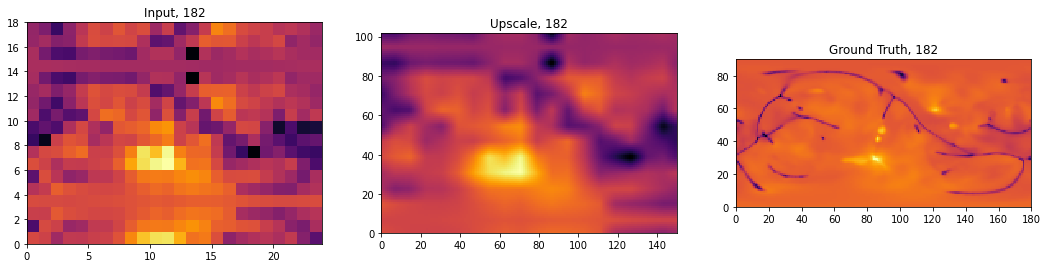

In [7]:
roll_n = np.random.randint(0,12) # amount to roll the input
title_list = ['Input', "Upscale", 'Ground Truth']
r_index = 182
var_to_plot = 'temperature'

# input to the generator will be of shape (1, 4, 198, 18, 28)
# therefore, pad the downscaled x to the appropriate size
x_input = np.roll(x, roll_n, 4)
# x_input = pad_data(x_input, pad_top_bot=3, pad_sides=2)
print(f'x input shape: \t\t\t {str(x.shape):10}')

# need an upsampled version of the x input
# this will be concatenated onto both the generator output
# and the true value as input to the descriminator
x_up = F.interpolate(torch.tensor(x_input), scale_factor=(1,8,8),
                      mode='trilinear', align_corners=False)
print(x_up.shape)

x_up = crop_x_data(x_up, crop_height=21, crop_width=21,)
print(x_up.shape)

# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                                
                ax.pcolormesh(x_input[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)
                
    # downscaled data
    if title == 'Upscale':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(x_up[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)
            
    # original data
    if title == 'Ground Truth':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(np.roll(x_truth[0,i,r_index,:,:],roll_n*8,1), cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)

plt.show()

### Try with Smaller Input Width

In [18]:
with h5py.File("x_orig_01.hdf5", "r") as f:
    x_orig = f["x"][:]
print('shape.x_orig:', x_orig.shape)

with h5py.File("x_01.hdf5", "r") as f:
    x = f["x"][:]
print('shape.x:', x.shape)
    
with open('r_index_full.pkl', 'rb') as f:
    r_index = pickle.load(f)
        
with open('var_list.pkl', 'rb') as f:
    var_list = pickle.load(f)
print(var_list)

shape.x_orig: (1, 4, 198, 90, 180)
shape.x: (1, 4, 198, 18, 24)
['temperature', 'vx', 'vy', 'vz', 'thermal conductivity', 'thermal expansivity', 'temperature anomaly', 'spin transition-induced density anomaly']


x input shape: 			 (1, 4, 198, 18, 8)
torch.Size([1, 4, 198, 102, 22])


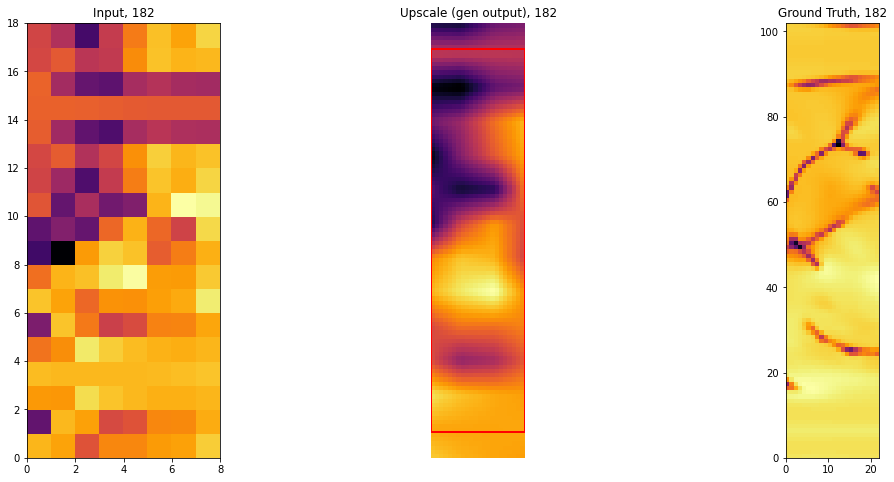

In [50]:
#!#!#! SMALL INPUT #!#!#!

with h5py.File("x_orig_01.hdf5", "r") as f:
    x_orig = f["x"][:]

with h5py.File("x_01.hdf5", "r") as f:
    x = f["x"][:]

# set parameters for data input
ROLL_N = np.random.randint(0,12) # amount to roll the input
# ROLL_N = 0 # set roll amount
INPUT_WIDTH = 8 # input width

# input to the generator will be of shape (1, 4, 198, 18, 8)
# but the scaled down x has shape (1, 4, 198, 12, 24)
# therefore, pad top/bot and crop width (sides)
x_input = np.roll(x, ROLL_N, 4) # roll if used
x_input = x_input[:,:,:,:,:INPUT_WIDTH] # select first N points for width
print(f'x input shape: \t\t\t {str(x_input.shape):10}')


# output from generator is (1, 4, 198, 102, 22)
# but compare this to 8x upscaled (1, 4, 198, 144, 64)
# therefore, need to crop the x_up (upscaled) to match dimension
# and pad/crop x_orig to match


# need an upsampled version of the x input
# this will be concatenated onto both the generator output
# and the true value as input to the descriminator
x_up = F.interpolate(torch.tensor(x_input), scale_factor=(1,8,8),
                      mode='trilinear', align_corners=False)

x_up = crop_x_data(x_up, crop_height=21, crop_width=21,)
print(x_up.shape)

# need the x_orig to match the output from the geneator with HxW = 102x22
# before downscale we padded x_orig by 6 on width/height
# and pad top/bot by 6 to get H=102
x_truth = np.roll(x_orig, ROLL_N*8, 4) # incase of roll
x_truth = pad_data(x_truth, pad_top_bot=6, pad_sides=6)


# crop x_truth to match generator output
x_truth = x_truth[:,:,:,:,21:21+22]
x_truth.shape

#!#!#!#!# PLOT
title_list = ['Input', "Upscale", 'Ground Truth']
r_index = 182
var_to_plot = 'temperature'


# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                                
                ax.pcolormesh(x_input[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)
                
    # downscaled data
    if title == 'Upscale':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(x_up[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title} (gen output), {r_index}")
                ax.set_aspect(1)
                
                # Create a Rectangle patch
                rect = patches.Rectangle((0, 6), 22, 90, linewidth=2, edgecolor='r', facecolor='none')
                ax.axis('off')

                # Add the patch to the Axes
                ax.add_patch(rect)
            
    # original data
    if title == 'Ground Truth':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(x_truth[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)

plt.show()

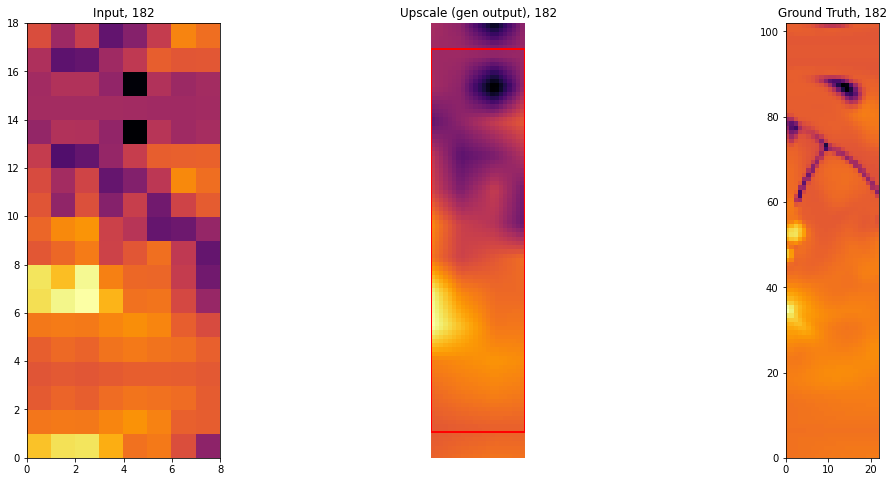

In [36]:
title_list = ['Input', "Upscale", 'Ground Truth']
r_index = 182
var_to_plot = 'temperature'


# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                                
                ax.pcolormesh(x_input[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)
                
    # downscaled data
    if title == 'Upscale':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(x_up[0,i,r_index,:,:], cmap=color_scheme, edgecolors='none')
                ax.set_title(f"{title} (gen output), {r_index}")
                ax.set_aspect(1)
                
                # Create a Rectangle patch
                rect = patches.Rectangle((0, 6), 22, 90, linewidth=2, edgecolor='r', facecolor='none')
                ax.axis('off')

                # Add the patch to the Axes
                ax.add_patch(rect)
            
    # original data
    if title == 'Ground Truth':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(x_truth[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)

plt.show()

x input shape: 			 (1, 4, 198, 12, 24)
torch.Size([1, 4, 198, 144, 64])


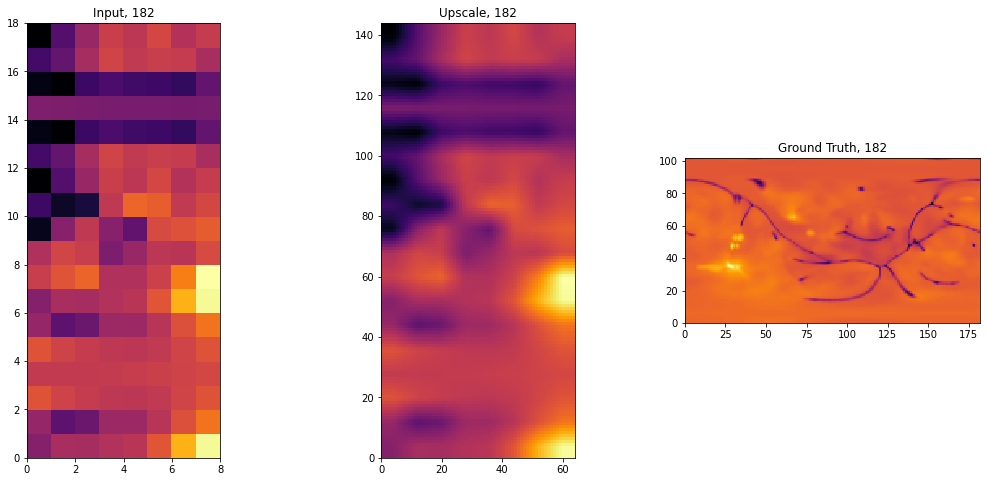

In [20]:
### SMALLER INPUT
# roll_n = np.random.randint(0,12) # amount to roll the input
roll_n = 4
title_list = ['Input', "Upscale", 'Ground Truth']
r_index = 182
var_to_plot = 'temperature'
crop_width = 8

# input to the generator will be of shape (1, 4, 198, 18, 8)
# therefore, pad top/bot and crop width (sides)
x_input = np.roll(x, roll_n, 4)
x_input = pad_data(x_input, pad_top_bot=3,)
x_input = x_input[:,:,:,:,:crop_width]
print(f'x input shape: \t\t\t {str(x.shape):10}')

# need an upsampled version of the x input
# this will be concatenated onto both the generator output
# and the true value as input to the descriminator
x_up = F.interpolate(torch.tensor(x_input), scale_factor=(1,8,8),
                      mode='trilinear', align_corners=False)
print(x_up.shape)

# x_up = crop_x_data(x_up, crop_height=21, crop_width=21,)
# print(x_up.shape)

# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                                
                ax.pcolormesh(x_input[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)
                
    # downscaled data
    if title == 'Upscale':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(x_up[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)
            
    # original data
    if title == 'Ground Truth':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(np.roll(x_truth[0,i,r_index,:,:],roll_n*8,1)[], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)

plt.show()

# Test GAN

Use https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/4.%20WGAN-GP/train.py to help with structure.

In [4]:
class G(nn.Module):
    def __init__(self, in_chan, out_chan, scale_factor=16,
                 chan_base=512, chan_min=64, chan_max=512, cat_noise=False,
                 **kwargs):
        super().__init__()

        self.scale_factor = scale_factor
        num_blocks = round(log2(self.scale_factor))

        assert chan_min <= chan_max

        def chan(b):
            c = chan_base >> b
            c = max(c, chan_min)
            c = min(c, chan_max)
            return c

        self.block0 = nn.Sequential(
            nn.Conv3d(in_chan, chan(0), 1),
            nn.LeakyReLU(0.2, True),
        )

        self.blocks = nn.ModuleList()
        for b in range(num_blocks):
            prev_chan, next_chan = chan(b), chan(b+1)
            self.blocks.append(
                HBlock(prev_chan, next_chan, out_chan, cat_noise))

    def forward(self, x):
        y = x  # direct upsampling from the input
        x = self.block0(x)

        #y = None  # no direct upsampling from the input
        for block in self.blocks:
            x, y = block(x, y)

        return y


class HBlock(nn.Module):
    """The "H" block of the StyleGAN2 generator.

        x_p                     y_p
         |                       |
    convolution           linear upsample
         |                       |
          >--- projection ------>+
         |                       |
         v                       v
        x_n                     y_n

    See Fig. 7 (b) upper in https://arxiv.org/abs/1912.04958
    Upsampling are all linear, not transposed convolution.

    Parameters
    ----------
    prev_chan : number of channels of x_p
    next_chan : number of channels of x_n
    out_chan : number of channels of y_p and y_n
    cat_noise: concatenate noise if True, otherwise add noise

    Notes
    -----
    next_size = 2 * prev_size - 6
    """
    def __init__(self, prev_chan, next_chan, out_chan, cat_noise):
        super().__init__()

        self.upsample = Resampler(3, 2)

        self.conv = nn.Sequential(
            AddNoise(cat_noise, chan=prev_chan),
            self.upsample,
            nn.Conv3d(prev_chan + int(cat_noise), next_chan, 3),
            nn.LeakyReLU(0.2, True),

            AddNoise(cat_noise, chan=next_chan),
            nn.Conv3d(next_chan + int(cat_noise), next_chan, 3),
            nn.LeakyReLU(0.2, True),
        )

        self.proj = nn.Sequential(
            nn.Conv3d(next_chan, out_chan, 1),
            nn.LeakyReLU(0.2, True),
        )

    def forward(self, x, y):
        x = self.conv(x)  # narrow by 3

        if y is None:
            y = self.proj(x)
        else:
            y = self.upsample(y)  # narrow by 1

            y = narrow_by(y, 2)

            y = y + self.proj(x)

        return x, y


class AddNoise(nn.Module):
    """Add or concatenate noise.

    Add noise if `cat=False`.
    The number of channels `chan` should be 1 (StyleGAN2)
    or that of the input (StyleGAN).
    """
    def __init__(self, cat, chan=1):
        super().__init__()

        self.cat = cat

        if not self.cat:
            self.std = nn.Parameter(torch.zeros([chan]))

    def forward(self, x):
        noise = torch.randn_like(x[:, :1])

        if self.cat:
            x = torch.cat([x, noise], dim=1)
        else:
            std_shape = (-1,) + (1,) * (x.dim() - 2)
            noise = self.std.view(std_shape) * noise

            x = x + noise

        return x

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [7]:
gen = G(in_chan=4, out_chan=4, scale_factor=8, chan_base=64, chan_min=64, chan_max=128, cat_noise=False).to(device)

In [ ]:
# original
roll_n = np.random.randint(0,14) # amount to roll the input
print('roll_n', roll_n)
title_list = ['Input', "Upscale", 'Ground Truth']
r_index = 182
var_to_plot = 'temperature'

# input to the generator will be of shape (1, 4, 198, 18, 28)
# therefore, pad the downscaled x to the appropriate size
x_input = np.roll(x, roll_n, 4)
x_input = pad_data(x_input, pad_top_bot=3, pad_sides=2)
x_input = torch.tensor(x_input)
x_input_temp = x_input # for plotting only

# need an upsampled version of the x input
# this will be concatenated onto both the generator output
# and the true value as input to the descriminator
x_up = F.interpolate(x_input, scale_factor=(1,8,8),
                      mode='trilinear', align_corners=False)
x_up = crop_x_data(x_up, crop_height=21, crop_width=21,)

# need to trim input radial dim down to 30
index_keep = np.round(np.arange(0,x_input.shape[2], x_input.shape[2]/10.0)).astype(int)
x_input = x_input[:,:1,index_keep,:,:20]
x_input.shape

In [13]:
with h5py.File("x_truth_01.hdf5", "r") as f:
    x_truth = f["x_truth"][:]

with h5py.File("x_01.hdf5", "r") as f:
    x = f["x"][:]

roll_n = 4
title_list = ['Input', "Upscale", 'Ground Truth']
r_index = 182
var_to_plot = 'temperature'
crop_width = 8

# input to the generator will be of shape (1, 4, 198, 18, 8)
# therefore, pad top/bot and crop width (sides)
x_input = np.roll(x, roll_n, 4)
x_input = pad_data(x_input, pad_top_bot=3,)
x_input = x_input[:,:,:,:,:crop_width]


# input to the generator will be of shape (1, 4, 198, 18, 8)
# therefore, pad top/bot and crop width (sides)
x_input = np.roll(x, roll_n, 4)
x_input = pad_data(x_input, pad_top_bot=3,)
x_input = x_input[:,:,:,:,:crop_width]
x_input = torch.tensor(x_input)
x_input_temp = x_input # for plotting only

# need an upsampled version of the x input
# this will be concatenated onto both the generator output
# and the true value as input to the descriminator
x_up = F.interpolate(x_input, scale_factor=(1,8,8),
                      mode='trilinear', align_corners=False)
x_up = crop_x_data(x_up, crop_height=22, crop_width=22,)

# need to trim input radial dim down to 30
index_keep = np.round(np.arange(0,x_input.shape[2], x_input.shape[2]/30.0)).astype(int)
x_input = x_input[:,:,index_keep,:,:]
x_input.shape

torch.Size([1, 4, 30, 18, 8])

In [14]:
output = gen(x_input.to(device))
output.shape

torch.Size([1, 4, 198, 102, 22])

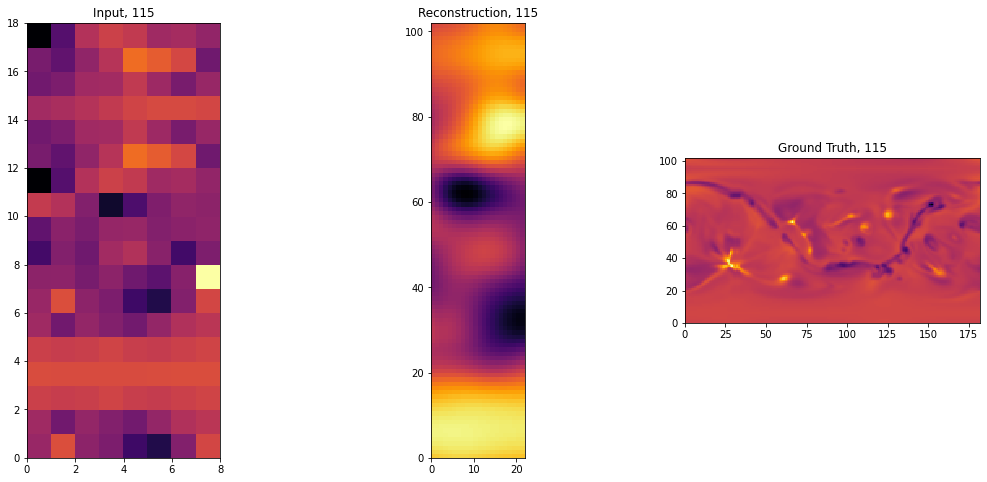

In [15]:
title_list = ['Input', "Reconstruction", 'Ground Truth']
r_index = 115
var_to_plot = 'temperature'

results = output[:,:,:,:,:].cpu().detach()


# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                                
                ax.pcolormesh(x_input_temp[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)
                
    # downscaled data
    if title == 'Reconstruction':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(results[0,i,r_index,:,:], cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)
                min_color = torch.min(results[0,i,r_index,:,:])
                max_color = torch.max(results[0,i,r_index,:,:])
            
    # original data
    if title == 'Ground Truth':
        for i, var_name in enumerate(var_list):
            if var_name == var_to_plot:
                
                ax.pcolormesh(np.roll(x_truth[0,i,r_index,:,:],roll_n*8,1), cmap=color_scheme)
                ax.set_title(f"{title}, {r_index}")
                ax.set_aspect(1)

plt.show()

In [66]:
# # make folder to save images if not already created
# img_folder = Path('img_results')
# pathlib.Path(img_folder).mkdir(parents=True, exist_ok=True)

# title_list = ['Input', "Reconstruction", 'Ground Truth']
# var_to_plot = 'temperature'

# results = output[:,:,:,:,:].cpu().detach()

# for r_index in range(results.shape[2]):
#     save_name = img_folder / f'r_index_{r_index}.jpg'

#     # create image
#     color_scheme='inferno'
#     fig, axes = plt.subplots(1,3, figsize=(18,8))

#     for ax, title in zip(axes.flat, title_list):

#         # downscaled data
#         if title == 'Input':
#             for i, var_name in enumerate(var_list):
#                 if var_name == var_to_plot:

#                     ax.pcolormesh(x_display[0,i,r_index,:,:], cmap=color_scheme)
#                     ax.set_title(f"{title}, {r_index}")
#                     ax.set_aspect(1)

#         # downscaled data
#         if title == 'Reconstruction':
#             for i, var_name in enumerate(var_list):
#                 if var_name == var_to_plot:

#                     ax.pcolormesh(results[0,i,r_index,:,:], cmap=color_scheme)
#                     ax.set_title(f"{title}, {r_index}")
#                     ax.set_aspect(1)
#                     min_color = torch.min(results[0,i,r_index,:,:])
#                     max_color = torch.max(results[0,i,r_index,:,:])

#         # original data
#         if title == 'Ground Truth':
#             for i, var_name in enumerate(var_list):
#                 if var_name == var_to_plot:

#                     ax.pcolormesh(x_2[0,i,r_index,:,:], cmap=color_scheme)
#                     ax.set_title(f"{title}, {r_index}")
#                     ax.set_aspect(1)

    

#     plt.savefig(save_name, bbox_inches = "tight")
#     plt.close('all')

Need to work on cropping the output...

"This transforms into an SRoutput of size 118^3 through the generator (see sizes annotated in Fig. 7),out of which we crop the inner part to match the corresponding (8×14)^3=112^3 grid from the HR target displacement field"

In [2]:
class D(nn.Module):
    def __init__(self, in_chan, out_chan, scale_factor=16,
                 chan_base=512, chan_min=64, chan_max=512,
                 **kwargs):
        super().__init__()

        self.scale_factor = scale_factor
        num_blocks = round(log2(self.scale_factor))

        assert chan_min <= chan_max

        def chan(b):
            if b >= 0:
                c = chan_base >> b
            else:
                c = chan_base << -b
            c = max(c, chan_min)
            c = min(c, chan_max)
            return c

        self.block0 = nn.Sequential(
            nn.Conv3d(in_chan, chan(num_blocks), 1),
            nn.LeakyReLU(0.2, True),
        )

        self.blocks = nn.ModuleList()
        for b in reversed(range(num_blocks)):
            prev_chan, next_chan = chan(b+1), chan(b)
            self.blocks.append(ResBlock(prev_chan, next_chan))

        self.block9 = nn.Sequential(
            nn.Conv3d(chan(0), chan(-1), 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv3d(chan(-1), 1, 1),
        )

    def forward(self, x):
        x = self.block0(x)

        for block in self.blocks:
            x = block(x)

        x = self.block9(x)

        return x


class ResBlock(nn.Module):
    """The residual block of the StyleGAN2 discriminator.

    Downsampling are all linear, not strided convolution.

    Notes
    -----
    next_size = (prev_size - 4) // 2
    """
    def __init__(self, prev_chan, next_chan):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv3d(prev_chan, prev_chan, 3),
            nn.LeakyReLU(0.2, True),

            nn.Conv3d(prev_chan, next_chan, 3),
            nn.LeakyReLU(0.2, True),
        )

        self.skip = nn.Conv3d(prev_chan, next_chan, 1)

        self.downsample = Resampler(3, 0.5)

    def forward(self, x):
        y = self.conv(x)

        x = self.skip(x)
        x = narrow_by(x, 2)

        x = x + y

        x = self.downsample(x)

        return x

# Train Loop

In [1]:
from math import log2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from narrow import narrow_by
from resample import Resampler

import h5py
import pickle
import pathlib
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(device)

cuda


In [3]:
class G(nn.Module):
    def __init__(self, in_chan, out_chan, scale_factor=16,
                 chan_base=512, chan_min=64, chan_max=512, cat_noise=False,
                 **kwargs):
        super().__init__()

        self.scale_factor = scale_factor
        num_blocks = round(log2(self.scale_factor))

        assert chan_min <= chan_max

        def chan(b):
            c = chan_base >> b
            c = max(c, chan_min)
            c = min(c, chan_max)
            return c

        self.block0 = nn.Sequential(
            nn.Conv3d(in_chan, chan(0), 1),
            nn.LeakyReLU(0.2, True),
        )

        self.blocks = nn.ModuleList()
        for b in range(num_blocks):
            prev_chan, next_chan = chan(b), chan(b+1)
            self.blocks.append(
                HBlock(prev_chan, next_chan, out_chan, cat_noise))

    def forward(self, x):
        y = x  # direct upsampling from the input
        x = self.block0(x)

        #y = None  # no direct upsampling from the input
        for block in self.blocks:
            x, y = block(x, y)

        return y


class HBlock(nn.Module):
    """The "H" block of the StyleGAN2 generator.

        x_p                     y_p
         |                       |
    convolution           linear upsample
         |                       |
          >--- projection ------>+
         |                       |
         v                       v
        x_n                     y_n

    See Fig. 7 (b) upper in https://arxiv.org/abs/1912.04958
    Upsampling are all linear, not transposed convolution.

    Parameters
    ----------
    prev_chan : number of channels of x_p
    next_chan : number of channels of x_n
    out_chan : number of channels of y_p and y_n
    cat_noise: concatenate noise if True, otherwise add noise

    Notes
    -----
    next_size = 2 * prev_size - 6
    """
    def __init__(self, prev_chan, next_chan, out_chan, cat_noise):
        super().__init__()

        self.upsample = Resampler(3, 2)

        self.conv = nn.Sequential(
            AddNoise(cat_noise, chan=prev_chan),
            self.upsample,
            nn.Conv3d(prev_chan + int(cat_noise), next_chan, 3),
            nn.LeakyReLU(0.2, True),

            AddNoise(cat_noise, chan=next_chan),
            nn.Conv3d(next_chan + int(cat_noise), next_chan, 3),
            nn.LeakyReLU(0.2, True),
        )

        self.proj = nn.Sequential(
            nn.Conv3d(next_chan, out_chan, 1),
            nn.LeakyReLU(0.2, True),
        )

    def forward(self, x, y):
        x = self.conv(x)  # narrow by 3

        if y is None:
            y = self.proj(x)
        else:
            y = self.upsample(y)  # narrow by 1

            y = narrow_by(y, 2)

            y = y + self.proj(x)

        return x, y


class AddNoise(nn.Module):
    """Add or concatenate noise.

    Add noise if `cat=False`.
    The number of channels `chan` should be 1 (StyleGAN2)
    or that of the input (StyleGAN).
    """
    def __init__(self, cat, chan=1):
        super().__init__()

        self.cat = cat

        if not self.cat:
            self.std = nn.Parameter(torch.zeros([chan]))

    def forward(self, x):
        noise = torch.randn_like(x[:, :1])

        if self.cat:
            x = torch.cat([x, noise], dim=1)
        else:
            std_shape = (-1,) + (1,) * (x.dim() - 2)
            noise = self.std.view(std_shape) * noise

            x = x + noise

        return x
    
class D(nn.Module):
    def __init__(self, in_chan, out_chan, scale_factor=16,
                 chan_base=512, chan_min=64, chan_max=512,
                 **kwargs):
        super().__init__()

        self.scale_factor = scale_factor
        num_blocks = round(log2(self.scale_factor))

        assert chan_min <= chan_max

        def chan(b):
            if b >= 0:
                c = chan_base >> b
            else:
                c = chan_base << -b
            c = max(c, chan_min)
            c = min(c, chan_max)
            return c

        self.block0 = nn.Sequential(
            nn.Conv3d(in_chan, chan(num_blocks), 1),
            nn.LeakyReLU(0.2, True),
        )

        self.blocks = nn.ModuleList()
        for b in reversed(range(num_blocks)):
            prev_chan, next_chan = chan(b+1), chan(b)
            self.blocks.append(ResBlock(prev_chan, next_chan))

        self.block9 = nn.Sequential(
            nn.Conv3d(chan(0), chan(-1), 1),
            nn.LeakyReLU(0.2, True),
            nn.Conv3d(chan(-1), 1, 1),
        )

    def forward(self, x):
        x = self.block0(x)

        for block in self.blocks:
            x = block(x)

        x = self.block9(x)

        return x


class ResBlock(nn.Module):
    """The residual block of the StyleGAN2 discriminator.

    Downsampling are all linear, not strided convolution.

    Notes
    -----
    next_size = (prev_size - 4) // 2
    """
    def __init__(self, prev_chan, next_chan):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv3d(prev_chan, prev_chan, 3),
            nn.LeakyReLU(0.2, True),

            nn.Conv3d(prev_chan, next_chan, 3),
            nn.LeakyReLU(0.2, True),
        )

        self.skip = nn.Conv3d(prev_chan, next_chan, 1)

        self.downsample = Resampler(3, 0.5)

    def forward(self, x):
        y = self.conv(x)

        x = self.skip(x)
        x = narrow_by(x, 2)

        x = x + y

        x = self.downsample(x)

        return x

In [4]:
def init_weights(m, init_weight_std=0.02):
    if isinstance(m, (nn.Linear, nn.Conv1d, nn.Conv2d, nn.Conv3d,
        nn.ConvTranspose1d, nn.ConvTranspose2d, nn.ConvTranspose3d)):
        m.weight.data.normal_(0.0, init_weight_std)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d,
        nn.SyncBatchNorm, nn.LayerNorm, nn.GroupNorm,
        nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d)):
        if m.affine:
            # NOTE: dispersion from DCGAN, why?
            m.weight.data.normal_(1.0, init_weight_std)
            m.bias.data.fill_(0)
            
def pad_data(x, pad_top_bot=5, pad_sides=5):

    if pad_sides > 0:
        x = torch.cat((x[:,:,:,:,-pad_sides:], x, x[:,:,:,:,:pad_sides]), axis=-1)
    
    if pad_top_bot > 0:
        x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_top_bot-1:-1,:], # mirror array and select top rows
                         x, 
                         torch.flip(x, [3])[:,:,:,1:pad_top_bot+1,:]), # mirror array and select bottom rows
                      axis=-2) # append along longitudinal (left-right) axis
        
    return x

def crop_x_data(x, crop_height=1, crop_width=1,):
    "symetrically crop tensor"
    w = crop_width
    h = crop_height
    
    if crop_width == 0 and crop_height == 0:
        return x
    elif crop_width == 0:
        return x[:,:,:,h:-h,:]
    elif crop_height == 0:
        return x[:,:,:,:,w:-w]
    else:
        return x[:,:,:,h:-h,w:-w]

In [5]:
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, R, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1, 1)).repeat(1, C, R, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

class WDistLoss(nn.Module):
    """Wasserstein distance

    target should have values of 0 (False) or 1 (True)
    """
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        return wasserstein_distance_loss(input, target)


def wasserstein_distance_loss(input, target):
    sign = 2 * target - 1

    return - (sign * input).mean()


def wgan_grad_penalty(critic, x, y, lam=10):
    """Calculate the gradient penalty for WGAN
    """
    device = x.device
    batch_size = x.shape[0]
    alpha = torch.rand(batch_size, device=device)
    alpha = alpha.reshape(batch_size, *(1,) * (x.dim() - 1))

    xy = alpha * x.detach() + (1 - alpha) * y.detach()

    score = critic(xy.requires_grad_(True))
    # average over spatial dimensions if present
    score = score.flatten(start_dim=1).mean(dim=1)
    # sum over batches because graphs are mostly independent (w/o batchnorm)
    score = score.sum()

    grad, = torch.autograd.grad(
        score,
        xy,
        retain_graph=True,
        create_graph=True,
        only_inputs=True,
    )

    grad = grad.flatten(start_dim=1)
    penalty = (
        lam * ((grad.norm(p=2, dim=1) - 1) ** 2).mean()
        + 0 * score  # hack to trigger DDP allreduce hooks
    )

    return penalty



Old...

In [6]:
# toggle create_small to make
# a smaller test data set to run
# on a small GPU
create_small = False

# load and prep data
with h5py.File("x_truth_01.hdf5", "r") as f:
    x_truth = torch.tensor(f["x_truth"][:])

if create_small:
    x_truth = x_truth[:,:1,:38,:,:]
else:
    x_truth = x_truth[:,:1,:,:,:]
    
print('shape.x_truth:', x_truth.shape)

with h5py.File("x_01.hdf5", "r") as f:
    x = torch.tensor(f["x"][:])
    
if create_small:
    x = x[:,:1,:38,:,:]
else:
    x = x[:,:1,:,:,:]
print('shape.x:', x.shape)


roll_n = np.random.randint(0,14) # amount to roll the input
# print('roll_n', roll_n)


# input to the generator will be of shape (1, 4, 198, 18, 28)
# therefore, pad the downscaled x to the appropriate size
x_input = torch.roll(x, roll_n, 4)
x_input = pad_data(x_input, pad_top_bot=3, pad_sides=2)

# need an upsampled version of the x input
# this will be concatenated onto both the generator output
# and the true value as input to the descriminator
x_up = F.interpolate(x_input, scale_factor=(1,8,8),
                      mode='trilinear', align_corners=False)
x_up = crop_x_data(x_up, crop_height=21, crop_width=21,)
print('x_up shape:',x_up.shape)


if create_small:
    index_keep = np.round(np.arange(0,x_input.shape[2], x_input.shape[2]/10.0)).astype(int)
    x_input = x_input[:,:,index_keep,:,:]
    print('x_input shape:', x_input.shape)
    
else:
    # need to trim input radial dim down to 30
    index_keep = np.round(np.arange(0,x_input.shape[2], x_input.shape[2]/30.0)).astype(int)
    x_input = x_input[:,:,index_keep,:,:]
    print('x_input shape:', x_input.shape)

# send to device
x_up = x_up.to(device, non_blocking=True)
x_input = x_input.to(device, non_blocking=True)
x_truth = x_truth.to(device, non_blocking=True)

shape.x_truth: torch.Size([1, 1, 198, 102, 182])
shape.x: torch.Size([1, 1, 198, 12, 24])
x_up shape: torch.Size([1, 1, 198, 102, 182])
x_input shape: torch.Size([1, 1, 30, 18, 28])


In [7]:
gen = G(in_chan=1, out_chan=1, scale_factor=8, chan_base=32, chan_min=32, chan_max=64, cat_noise=True).to(device)
critic = D(in_chan=2, out_chan=2, scale_factor=8, chan_base=32, chan_min=32, chan_max=64).to(device)

# initialize weights
gen.apply(init_weights)
critic.apply(init_weights)

# initializate optimizer
opt_gen = optim.Adam(gen.parameters(), lr=1e-4, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.0, 0.9))

gen.train()
critic.train()

# training loop
NUM_EPOCHS = 10
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10


for epoch in range(NUM_EPOCHS):
    print('epoch', epoch)
   
    for i in range(CRITIC_ITERATIONS):
        fake = gen(x_input)
        
#         loss = criterion(output, x_target)
        
        critic_real = critic(torch.cat([x_truth, x_up], dim=1)).view(-1)
        critic_fake = critic(torch.cat([fake, x_up], dim=1)).view(-1)
        
        gp = gradient_penalty(critic, 
                              torch.cat([x_truth, x_up], dim=1), # real
                              torch.cat([fake, x_up], dim=1),  # fake
                              device=device)

#         gp = wgan_grad_penalty(critic, torch.cat([fake, x_up], dim=1), torch.cat([x_truth, x_up], dim=1))
        
        loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
        
        critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        opt_critic.step()
        
    # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
    gen_fake = critic(torch.cat([fake, x_up], dim=1)).reshape(-1)
    loss_gen = -torch.mean(gen_fake)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
        

epoch 0


/home/tvhahn/torch1/lib/python3.7/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


RuntimeError: CUDA out of memory. Tried to allocate 432.00 MiB (GPU 0; 11.91 GiB total capacity; 10.22 GiB already allocated; 97.25 MiB free; 10.91 GiB reserved in total by PyTorch)

In [ ]:
torch.save(gen, 'gen.pt')

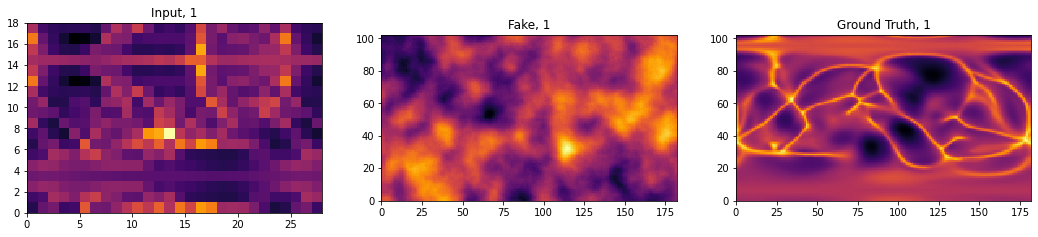

In [10]:
with torch.no_grad():
    fake = gen(x_input)

    
title_list = ['Input', "Fake", 'Ground Truth']
r_index = 1
# var_to_plot = 1
    
# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
                                
        ax.pcolormesh(x_input[0,0,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
                
    # downscaled data
    if title == 'Fake':
                
        ax.pcolormesh(fake[0,0,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
            
    # original data
    if title == 'Ground Truth':
           
        ax.pcolormesh(x_truth[0,0,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)

plt.show()

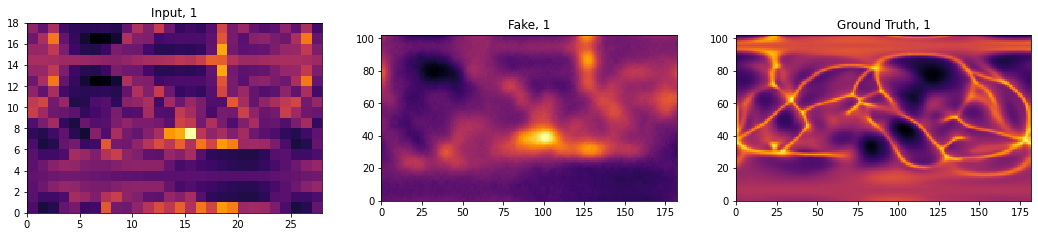

In [9]:
with torch.no_grad():
    fake = gen(x_input)

    
title_list = ['Input', "Fake", 'Ground Truth']
r_index = 1
# var_to_plot = 1
    
# create image
color_scheme='inferno'
fig, axes = plt.subplots(1,3, figsize=(18,8))

for ax, title in zip(axes.flat, title_list):
    
                
    # downscaled data
    if title == 'Input':
                                
        ax.pcolormesh(x_input[0,0,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
                
    # downscaled data
    if title == 'Fake':
                
        ax.pcolormesh(fake[0,0,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)
            
    # original data
    if title == 'Ground Truth':
           
        ax.pcolormesh(x_truth[0,0,r_index,:,:].cpu(), cmap=color_scheme)
        ax.set_title(f"{title}, {r_index}")
        ax.set_aspect(1)

plt.show()

In [32]:
fake.shape

torch.Size([1, 1, 38, 102, 182])

In [12]:
a = torch.cat([x_truth, x_up], dim=1)
a.shape

torch.Size([1, 2, 38, 102, 182])

In [13]:
a = critic(x_truth)
a.shape

RuntimeError: Given groups=1, weight of size [4, 2, 1, 1, 1], expected input[1, 1, 38, 102, 182] to have 2 channels, but got 1 channels instead

In [14]:
x_full_size = pad_data(x_full, pad_top_bot=11, pad_sides=0)

# x_full_size = torch.tensor(x_full_size[:,:,:,:112,:112])
x_full_size = torch.tensor(x_orig)
x_full_size.shape

torch.Size([1, 4, 198, 102, 182])

In [15]:
x_orig.shape

(1, 4, 198, 102, 182)

In [16]:
critic_result = critic(x_full_size.to(device))
critic_result.shape

/home/tim/miniconda3/envs/torch2/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


torch.Size([1, 1, 21, 9, 19])

In [17]:
critic_result

tensor([[[[[0.0437, 0.0437, 0.0432,  ..., 0.0431, 0.0429, 0.0428],
           [0.0443, 0.0443, 0.0450,  ..., 0.0421, 0.0425, 0.0427],
           [0.0413, 0.0413, 0.0437,  ..., 0.0419, 0.0422, 0.0426],
           ...,
           [0.0415, 0.0416, 0.0405,  ..., 0.0436, 0.0428, 0.0425],
           [0.0416, 0.0423, 0.0419,  ..., 0.0443, 0.0429, 0.0429],
           [0.0418, 0.0431, 0.0425,  ..., 0.0446, 0.0430, 0.0420]],

          [[0.0437, 0.0438, 0.0433,  ..., 0.0430, 0.0428, 0.0428],
           [0.0436, 0.0434, 0.0446,  ..., 0.0422, 0.0425, 0.0426],
           [0.0416, 0.0415, 0.0433,  ..., 0.0420, 0.0422, 0.0427],
           ...,
           [0.0416, 0.0417, 0.0411,  ..., 0.0436, 0.0428, 0.0425],
           [0.0419, 0.0423, 0.0420,  ..., 0.0441, 0.0430, 0.0430],
           [0.0422, 0.0430, 0.0423,  ..., 0.0447, 0.0431, 0.0419]],

          [[0.0437, 0.0438, 0.0433,  ..., 0.0428, 0.0428, 0.0428],
           [0.0432, 0.0428, 0.0442,  ..., 0.0423, 0.0425, 0.0425],
           [0.0418, 0.0416